In [15]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = False

In [16]:
# Dataset path
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'


In [17]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("INSERT PATH HERE").rglob("*.jpeg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [32]:
# Data Generation
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
print("Training set")
train_data = data_gen.flow_from_directory(train_path,
                                          target_size = (224, 224),
                                          batch_size = 16,
                                          class_mode = 'categorical',
                                          shuffle = True)
print("Testing set")
test_data = data_gen.flow_from_directory(test_path,
                                         target_size = (224, 224),
                                         batch_size = 16,
                                         class_mode = 'categorical',
                                         shuffle = False)



Training set
Found 6372 images belonging to 7 classes.
Testing set
Found 1525 images belonging to 7 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [21]:
from keras.layers.normalization.batch_normalization import BatchNormalization
# Creating Vgg-16 model
model = Sequential()

# Convolution layers
model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(1,1), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(1,1), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(4, 4),padding="same"))
model.add(BatchNormalization())

In [22]:
# Linear Layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=7, activation="softmax"))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      4160      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)    

In [24]:
from keras import optimizers
adam = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [25]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint=  ModelCheckpoint(filepath ='vgg16_1.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=65, min_delta=0.001)
history = model.fit(train_data,
                    steps_per_epoch=350,
                    epochs=100,
                    verbose=2,
                    validation_data=test_data,validation_steps=50,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/100
350/350 - 37s - loss: 0.7135 - accuracy: 0.7853 - val_loss: 0.5376 - val_accuracy: 0.8000 - 37s/epoch - 107ms/step
Epoch 2/100
350/350 - 36s - loss: 0.6376 - accuracy: 0.8146 - val_loss: 0.4687 - val_accuracy: 0.8250 - 36s/epoch - 104ms/step
Epoch 3/100
350/350 - 36s - loss: 0.6625 - accuracy: 0.8114 - val_loss: 0.3815 - val_accuracy: 0.8700 - 36s/epoch - 102ms/step
Epoch 4/100
350/350 - 36s - loss: 0.5643 - accuracy: 0.8289 - val_loss: 0.5072 - val_accuracy: 0.8250 - 36s/epoch - 102ms/step
Epoch 5/100
350/350 - 35s - loss: 0.4600 - accuracy: 0.8710 - val_loss: 0.6991 - val_accuracy: 0.7750 - 35s/epoch - 101ms/step
Epoch 6/100
350/350 - 36s - loss: 0.3115 - accuracy: 0.9123 - val_loss: 0.4164 - val_accuracy: 0.8662 - 36s/epoch - 102ms/step
Epoch 7/100
350/350 - 35s - loss: 0.3453 - accuracy: 0.9055 - val_loss: 0.4147 - val_accuracy: 0.8550 - 35s/epoch - 101ms/step
Epoch 8/100
350/350 - 36s - loss: 0.2998 - accuracy: 0.9137 - val_loss: 0.3352 - val_accuracy: 0.8938 - 36s/epo

Epoch 65/100
350/350 - 35s - loss: 2.9969e-04 - accuracy: 1.0000 - val_loss: 0.3249 - val_accuracy: 0.9312 - 35s/epoch - 100ms/step
Epoch 66/100
350/350 - 35s - loss: 9.6289e-04 - accuracy: 0.9998 - val_loss: 0.3067 - val_accuracy: 0.9337 - 35s/epoch - 100ms/step
Epoch 67/100
350/350 - 35s - loss: 5.2046e-04 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 0.9325 - 35s/epoch - 101ms/step
Epoch 68/100
350/350 - 35s - loss: 2.4415e-04 - accuracy: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.9350 - 35s/epoch - 101ms/step
Epoch 69/100
350/350 - 35s - loss: 6.2628e-04 - accuracy: 0.9998 - val_loss: 0.3083 - val_accuracy: 0.9350 - 35s/epoch - 100ms/step
Epoch 70/100
350/350 - 35s - loss: 5.1388e-04 - accuracy: 1.0000 - val_loss: 0.3105 - val_accuracy: 0.9375 - 35s/epoch - 101ms/step
Epoch 71/100
350/350 - 35s - loss: 4.6959e-04 - accuracy: 0.9998 - val_loss: 0.3044 - val_accuracy: 0.9375 - 35s/epoch - 100ms/step
Epoch 72/100
350/350 - 35s - loss: 3.7000e-04 - accuracy: 1.0000 - val_loss:

In [49]:
from tensorflow.keras import models
model.load_weights("vgg16_1.hdf5")

In [50]:
predictions = model.predict(test_data, steps=1525/16, verbose=0)

In [51]:
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)

targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_data.classes

#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.90      0.93      0.91        40
         bcc       0.96      1.00      0.98        48
         bkl       0.88      0.96      0.92       124
          df       0.79      1.00      0.88        11
         mel       0.63      0.97      0.76        63
          nv       0.99      0.95      0.97      1222
        vasc       0.73      0.94      0.82        17

    accuracy                           0.95      1525
   macro avg       0.84      0.96      0.89      1525
weighted avg       0.96      0.95      0.95      1525



In [52]:
from sklearn.metrics import roc_auc_score
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9619731468533602
Recall: 0.9514754098360656
Accuracy: 0.9514754098360656
weighted Roc score: 0.9922014612147626


In [53]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9995622895622895
The ROC AUC score of bcc is: 0.9998730534867976
The ROC AUC score of bkl is: 0.9936968985287007
The ROC AUC score of df is: 0.9996997718265882
The ROC AUC score of mel is: 0.9926172019195275
The ROC AUC score of nv is: 0.9913143523845018
The ROC AUC score of vasc is: 0.9996879388360119


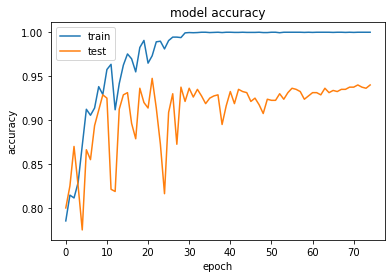

In [54]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

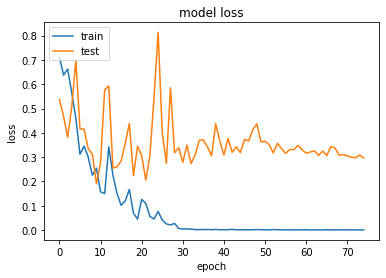

In [55]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()